In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from abcd.local.paths import core_path, output_path
from abcd.data.read_data import get_subjects_events, add_event_vars
from abcd.data.NETWORKS import NAMED_CONNECTIONS
from abcd.data.VARS import CBCL_SCORES_t as CBCL_SCORES
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.var_tailoring.residualization import residualize
from abcd.data.var_tailoring.normalization import normalize_var
from abcd.analysis.methods.sklearn.sklearn_cca import fit_cca
from abcd.plotting.seaborn.scatter import plot_scatter
from abcd.plotting.seaborn.correlations import plot_correlations
from abcd.plotting.matplotlib.cca_plot import plot_cca_rotations

In [3]:
k = 5
subjects_df, events_df = get_subjects_events()
splits = save_restore_sex_fmri_splits(k=k)
print("There are {} events for {} subjects".format(len(events_df), len(subjects_df)))

There are 19605 events for 9879 subjects


In [4]:
# Replace 'don't know' and 'refuse to answer'
subjects_df["kbi_sex_assigned_at_birth"] = subjects_df["kbi_sex_assigned_at_birth"].replace(777.0, 1.5).replace(999.0, 1.5)

# Add the sex assigned at birth to the events df
events_df = pd.merge(events_df, subjects_df[['src_subject_id','kbi_sex_assigned_at_birth']], on='src_subject_id', how='left')

# Add mental health scores
mental_health_file = os.path.join(core_path, "mental-health", "mh_p_cbcl.csv")
events_df = add_event_vars(events_df, mental_health_file, vars=list(CBCL_SCORES.keys()))
print("From those, there are {} events with mental health scores".format(len(events_df)))

# Remove missing values
events_df = events_df.dropna()
print("After removing missing values, the df has {} events".format(len(events_df)))

From those, there are 19573 events with mental health scores
After removing missing values, the df has 18370 events


c:\users\camgonza\desktop\abcd5\abcd\utils\io.py:24: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=sep)


In [5]:
# Normalize funcional connectivity and mental helth scores in the (0, 1) range, and residualize
# the sex and age effects from the connectivity scores (not from the mh scores as we are taking the 
# t scores)
for var_id in CBCL_SCORES.keys():
    events_df = normalize_var(events_df, var_id, var_id)
for var_id in NAMED_CONNECTIONS.keys():
    events_df = residualize(events_df, var_id, var_id, covs = ["interview_age", "kbi_sex_assigned_at_birth"],
                references = {"kbi_sex_assigned_at_birth": 1.0})
    events_df = normalize_var(events_df, var_id, var_id)
    
# Rename columns
events_df = events_df.rename(columns=CBCL_SCORES)
events_df = events_df.rename(columns=NAMED_CONNECTIONS)

                   Generalized Linear Model Regression Results                    
Dep. Variable:     rsfmri_c_ngd_ad_ngd_ad   No. Observations:                18370
Model:                                GLM   Df Residuals:                    18367
Model Family:                    Gaussian   Df Model:                            2
Link Function:                   Identity   Scale:                       0.0064636
Method:                              IRLS   Log-Likelihood:                 20242.
Date:                    Fri, 14 Jul 2023   Deviance:                       118.72
Time:                            10:52:15   Pearson chi2:                     119.
No. Iterations:                         3   Pseudo R-squ. (CS):           0.004835
Covariance Type:                nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [6]:
feature_columns = list(NAMED_CONNECTIONS.values())
target_columns = list(CBCL_SCORES.values())
nr_components = 3
cca_model, events_df = fit_cca(events_df, feature_columns, target_columns, nr_components=nr_components)
cc_x_cols, cc_y_cols = ["CC{}_X".format(dim+1) for dim in range(nr_components)], ["CC{}_Y".format(dim+1) for dim in range(nr_components)]

Covariate on dimension 1 has correlation 0.19
Covariate on dimension 2 has correlation 0.15
Covariate on dimension 3 has correlation 0.12


In [37]:
print(len(events_df))

18370


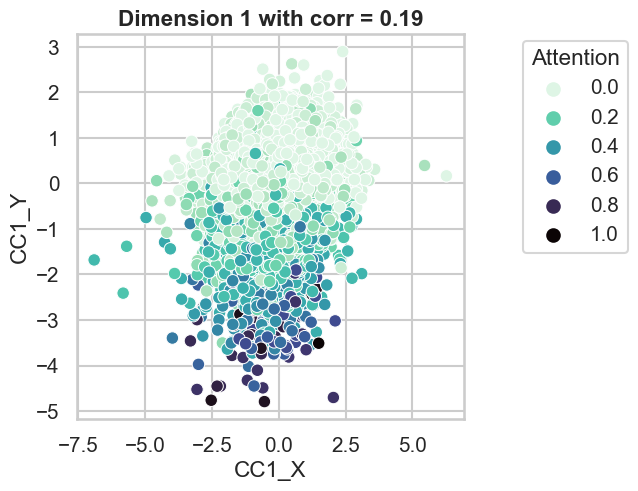

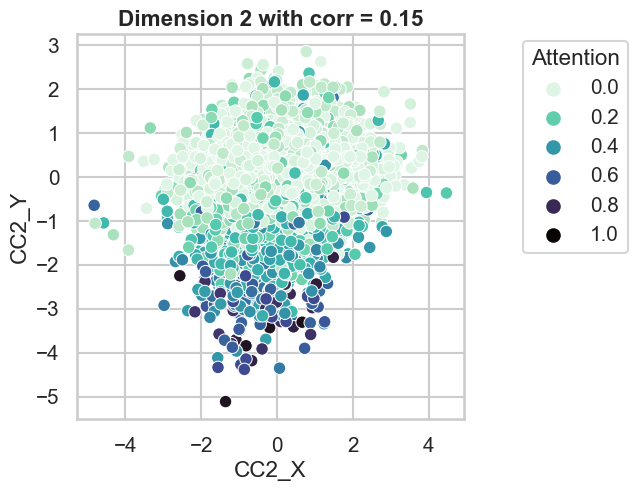

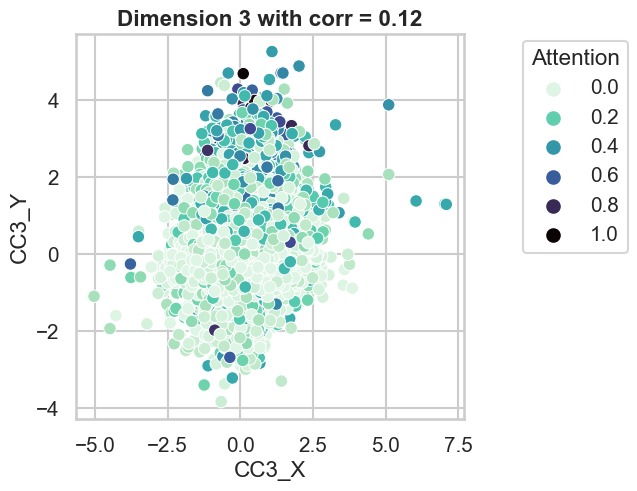

In [21]:
from abcd.plotting.seaborn.rendering import save, display_svg
# Plot correlations
hue_col = "Attention"
for dim in range(nr_components):
    x_col, y_col = "CC{0}_X".format(dim+1), "CC{0}_Y".format(dim+1)
    title = "Dimension {0} with corr = {1:.2f}".format(dim+1, np.corrcoef(events_df["CC{0}_X".format(dim+1)], events_df["CC{}_Y".format(dim+1)])[0][1])
    plot = plot_scatter(events_df, x_col, y_col, hue_col, title)
    display_svg(plot)
    

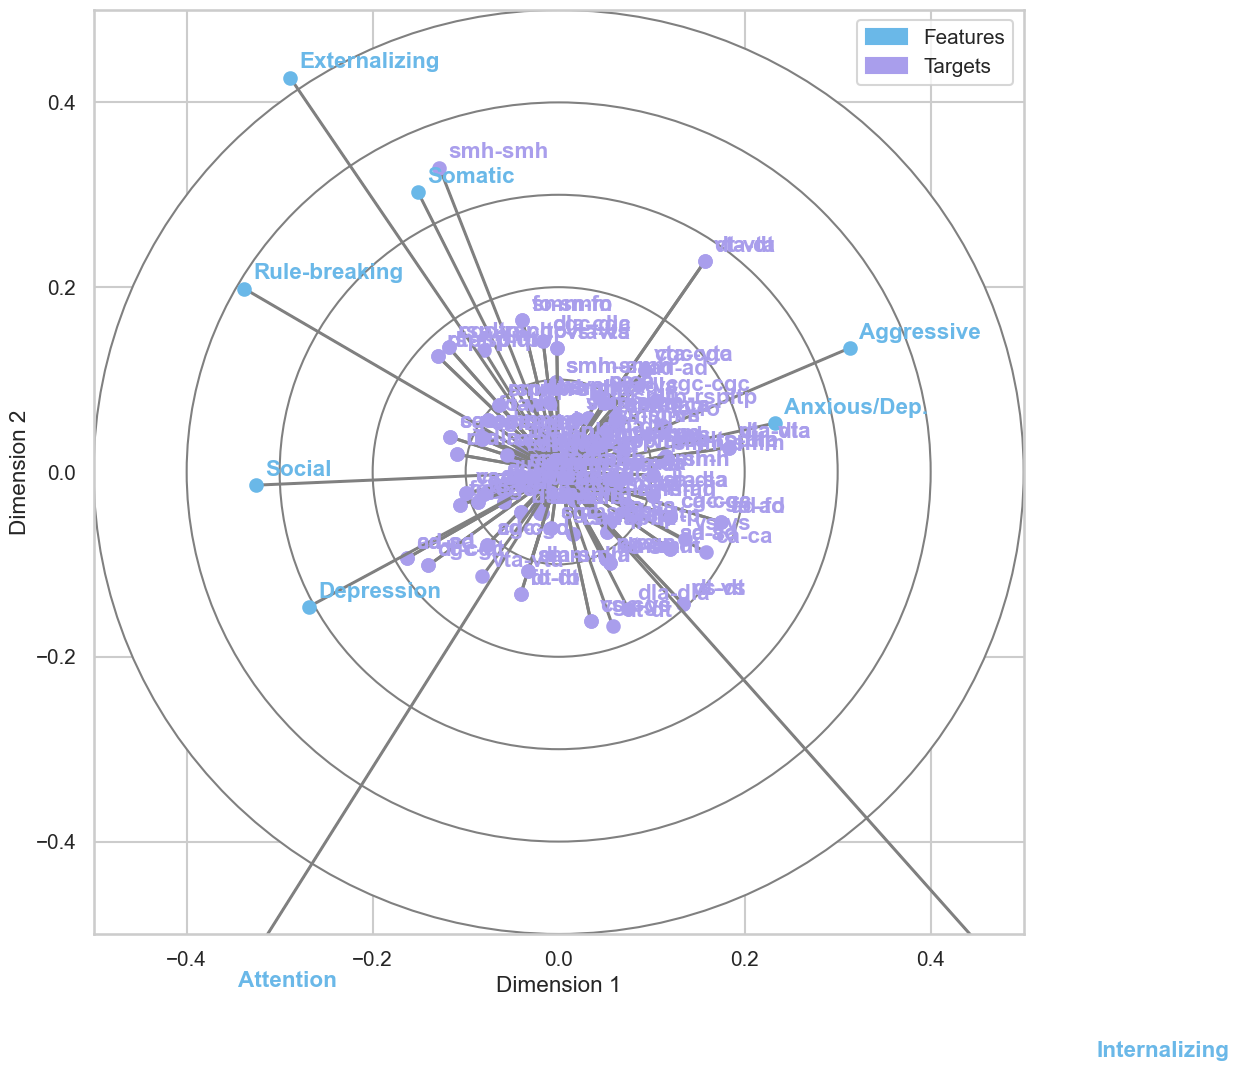

In [10]:

plot = plot_cca_rotations(cca_model, x_vars=feature_columns, y_vars=target_columns, x_component=0, y_component=1)
save(plot, output_path, 'cca_rotations', ending='.png')

<module 'matplotlib.pyplot' from 'c:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

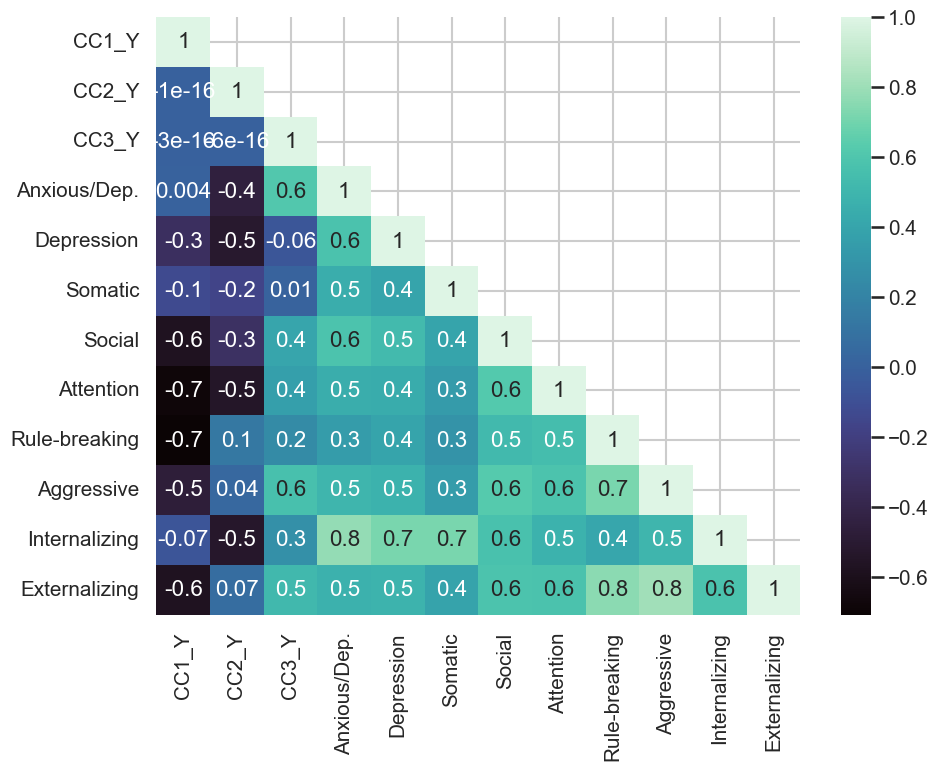

In [22]:
plot_correlations(events_df, columns=cc_y_cols + target_columns)

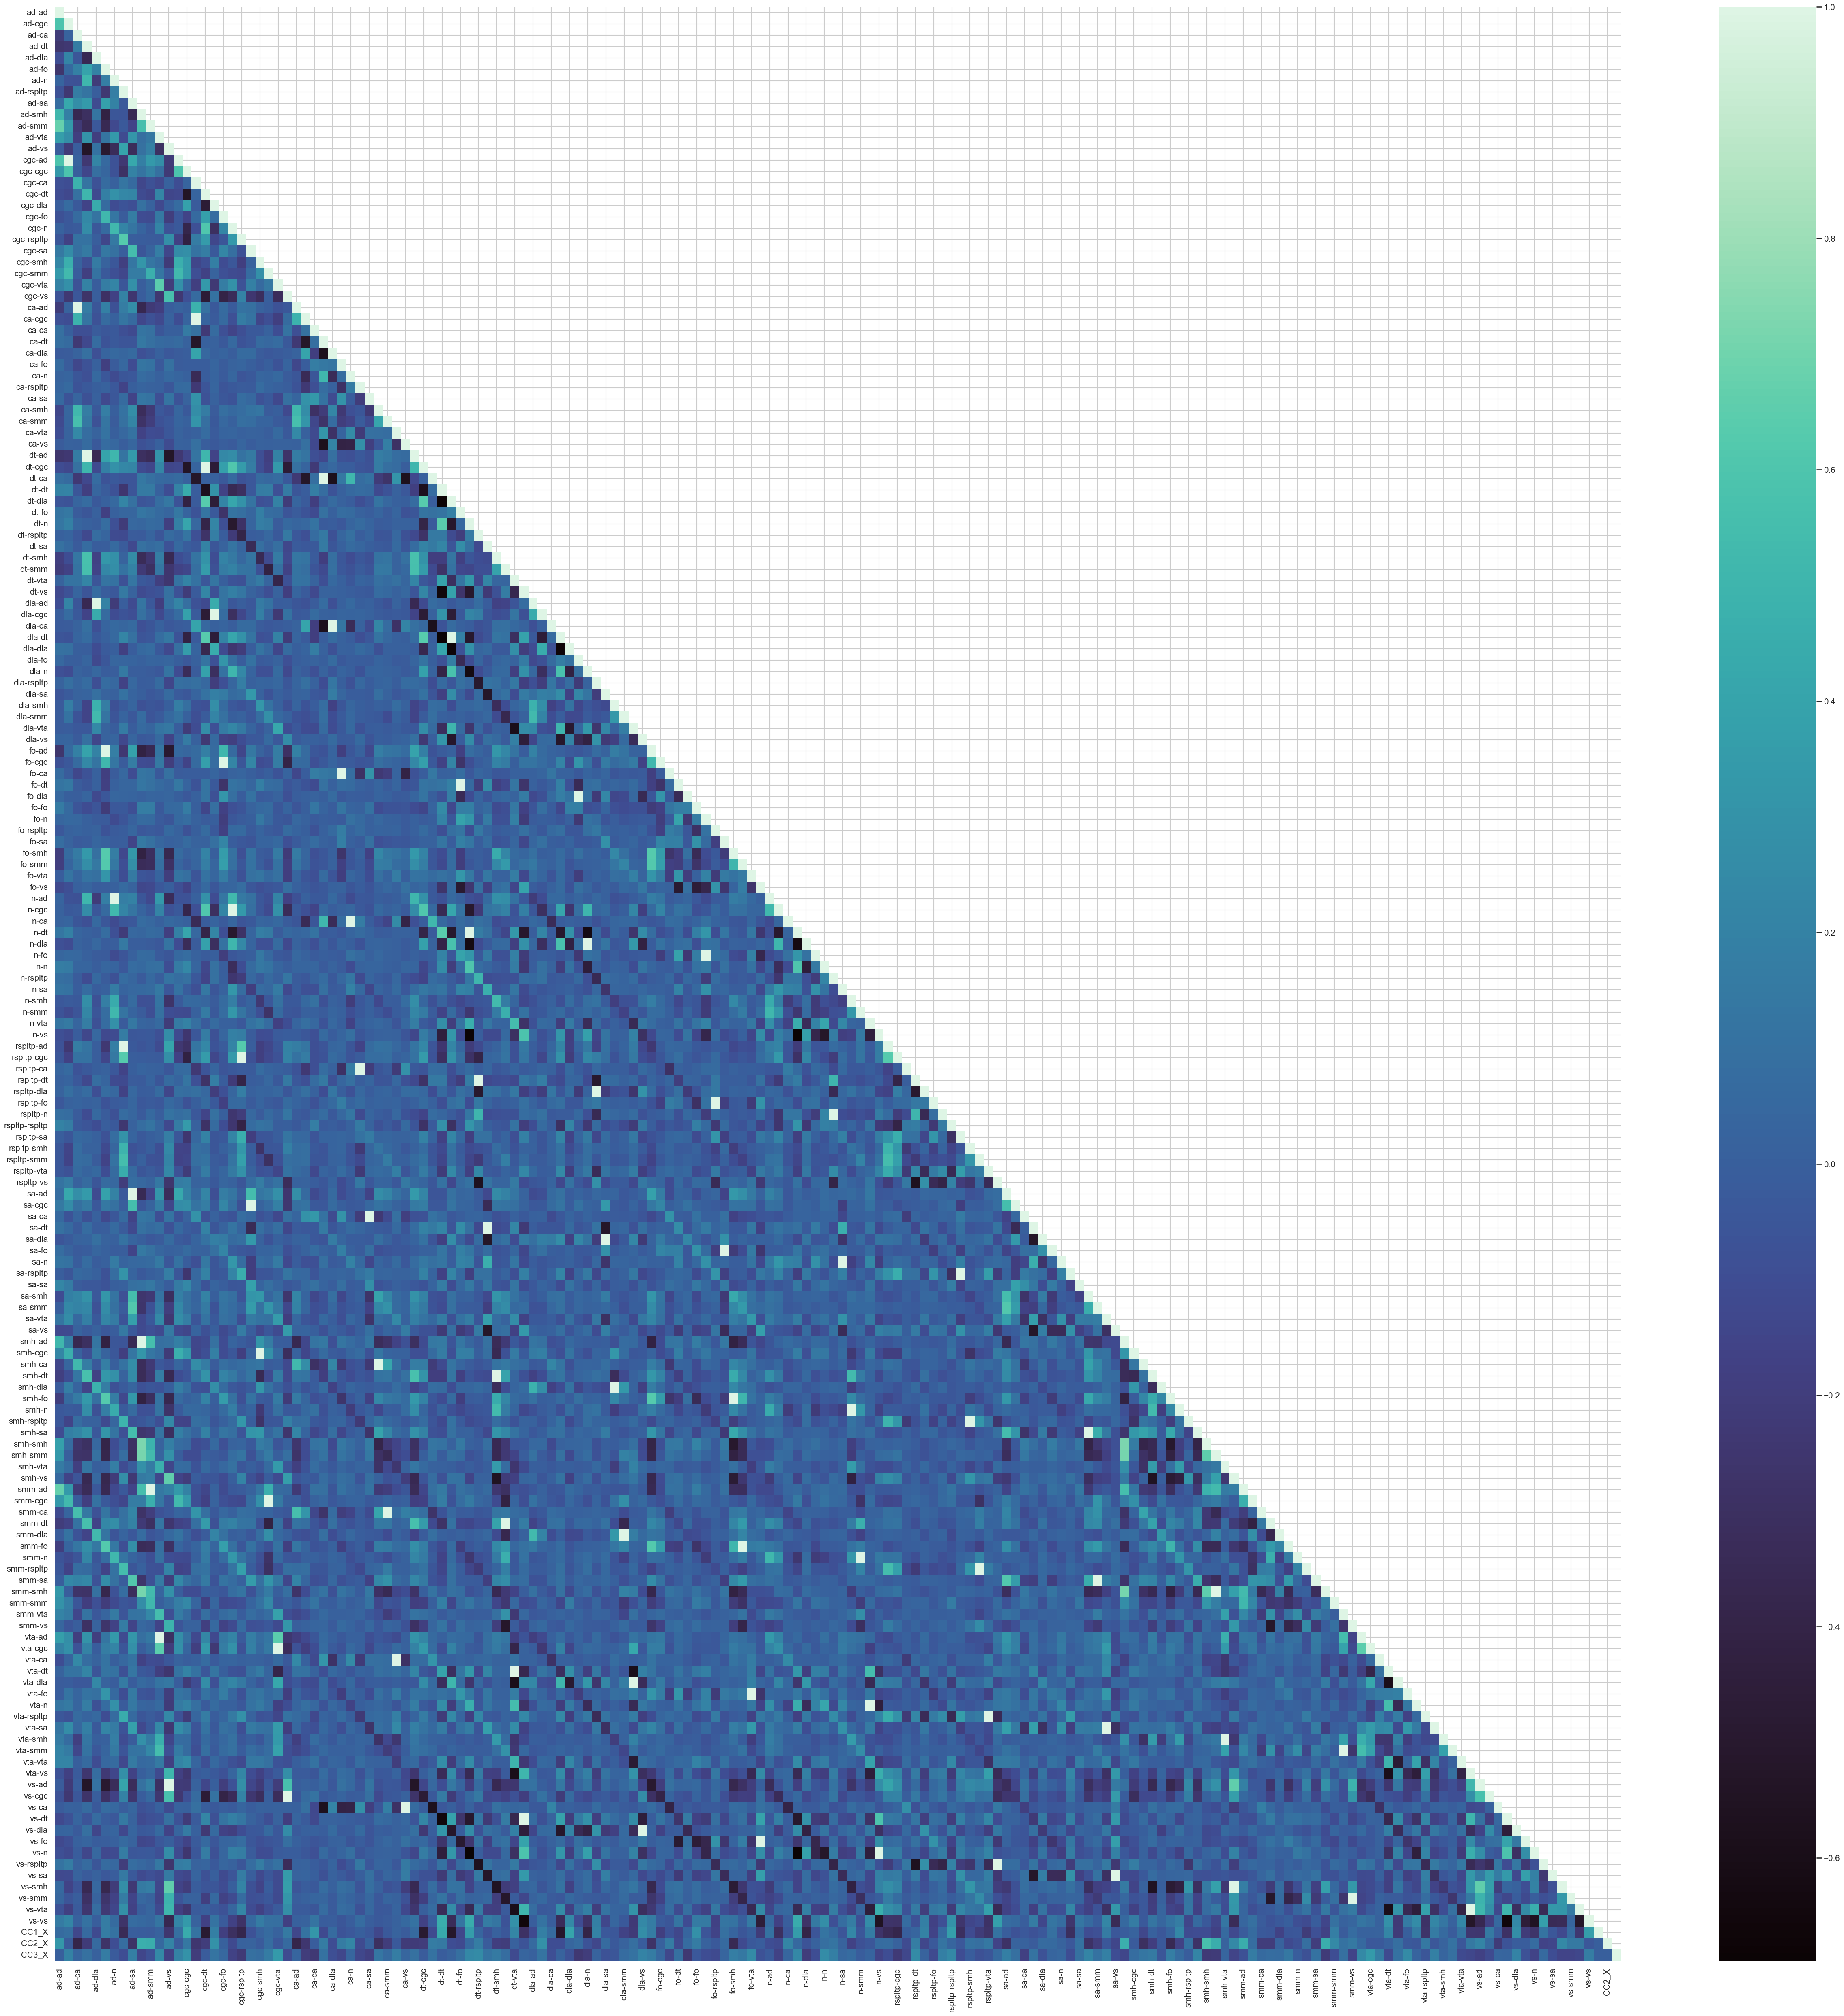

In [28]:
plot = plot_correlations(events_df, columns=feature_columns + cc_x_cols, figsize=(50, 50), annot=False)
save(plot, output_path, 'x_correlations', ending='.png')

In [29]:
# Select only the k variables with higher correlation
columns = cc_x_cols + cc_y_cols + feature_columns + target_columns
corr_df = events_df[columns].copy()
corr_matrix = corr_df.corr(method='pearson')

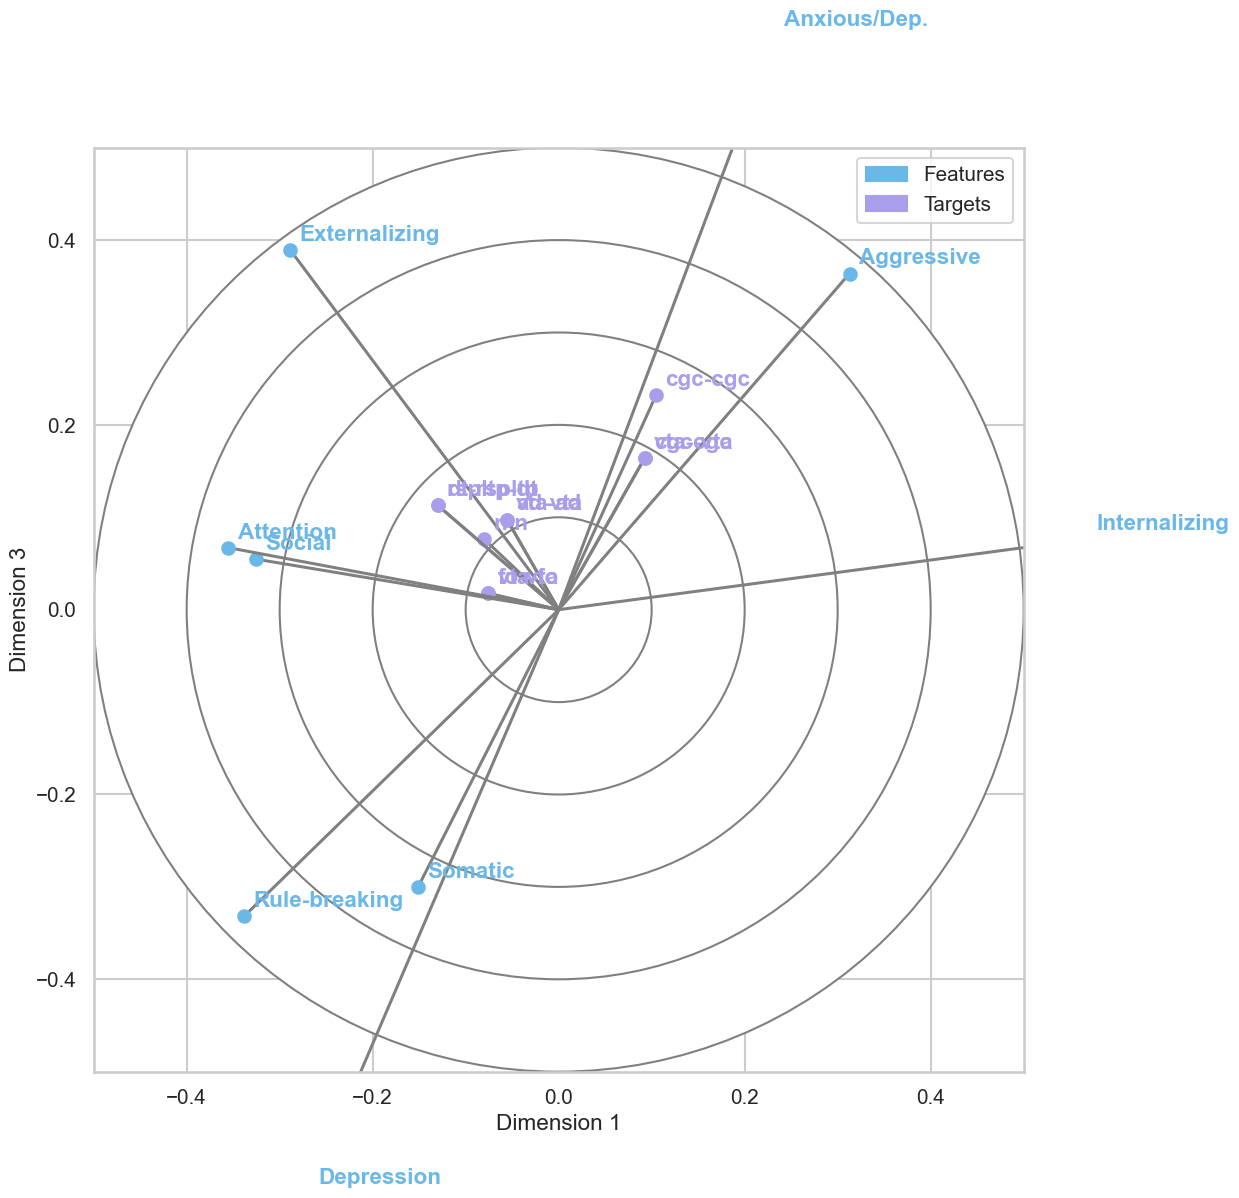

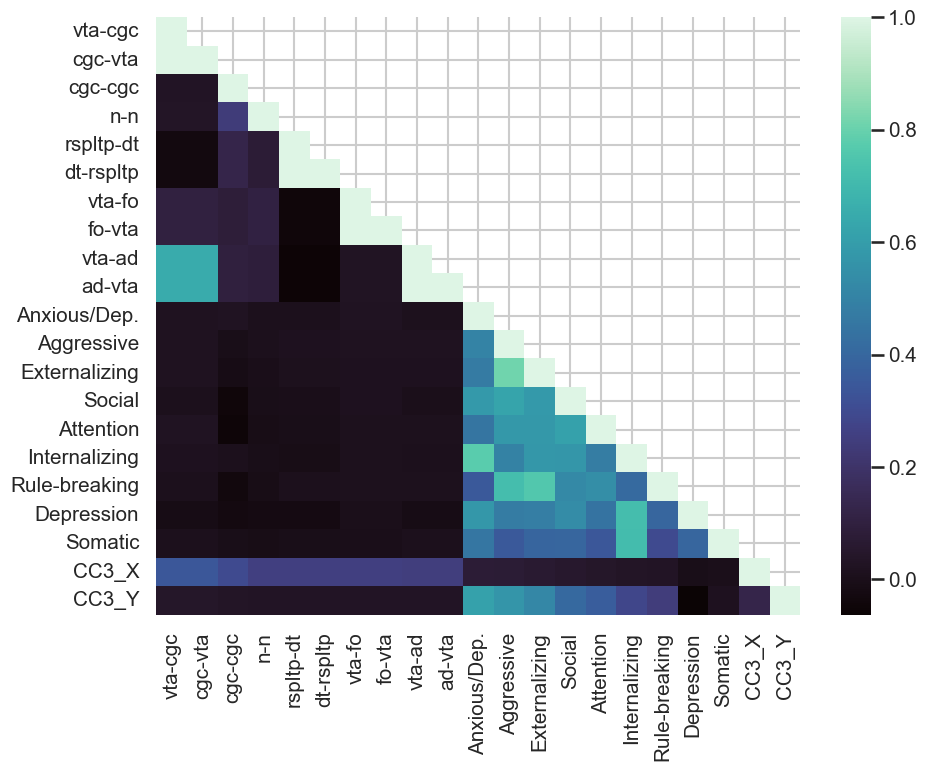

In [36]:
# For each dimension, select a subset of feature columns and target columns with highest correlation
nr_feature_cols = 10
nr_target_cols = 9
dimension_corrs = corr_matrix.to_dict()

dim = 2
feature_corrs = sorted([(abs(v), k) for k, v in dimension_corrs["CC{}_X".format(dim+1)].items() if k in feature_columns], reverse=True)[:nr_feature_cols]
target_corrs = sorted([(abs(v), k) for k, v in dimension_corrs["CC{}_Y".format(dim+1)].items() if k in target_columns], reverse=True)[:nr_target_cols]
features_subset, targets_subset = [x[1] for x in feature_corrs],  [x[1] for x in target_corrs]
plot = plot_cca_rotations(cca_model, x_vars=feature_columns, y_vars=target_columns, x_component=0, y_component=2, include_vars=features_subset+targets_subset)
save(plot, output_path, 'Dimension {} rotations highest corr'.format(dim), ending='.png')
plot = plot_correlations(events_df, columns=features_subset+targets_subset+["CC{}_X".format(dim+1), "CC{}_Y".format(dim+1)], annot=False)
save(plot, output_path, 'Dimension {} correlations highest corr'.format(dim), ending='.png')
